In [55]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import matplotlib.pyplot as plt

# For Prediction:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# For nice Plots
%matplotlib inline
plt.style.use('default')

# Read in the data

In [11]:
dir_path = os.path.abspath("")
fname = dir_path+'\FAOSTAT_data_en_12-16-2022.csv'
print(fname)
df = pd.read_csv(fname, encoding='latin-1')

c:\Users\wb8by\Documents\GitHub\Supply-Chain\FAOSTAT_data_en_12-16-2022.csv


# Columns Names/First Five Lines

In [12]:
df.head()

,ï»¿Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,FS,Suite of Food Security Indicators,12,Algeria,6121,Value,21010,Average dietary energy supply adequacy (percen...,20002002,2000-2002,%,127,E,Estimated value,NaN
1,FS,Suite of Food Security Indicators,12,Algeria,6121,Value,21010,Average dietary energy supply adequacy (percen...,20012003,2001-2003,%,129,E,Estimated value,NaN
2,FS,Suite of Food Security Indicators,12,Algeria,6121,Value,21010,Average dietary energy supply adequacy (percen...,20022004,2002-2004,%,130,E,Estimated value,NaN
3,FS,Suite of Food Security Indicators,12,Algeria,6121,Value,21010,Average dietary energy supply adequacy (percen...,20032005,2003-2005,%,130,E,Estimated value,NaN
4,FS,Suite of Food Security Indicators,12,Algeria,6121,Value,21010,Average dietary energy supply adequacy (percen...,20042006,2004-2006,%,131,E,Estimated value,NaN


# Initial Missing Data Count

In [13]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total','Percent'])
missing_data

,Total,Percent
Note,39537,0.987117
Value,5981,0.149327
Flag,982,0.024518
Flag Description,982,0.024518
ï»¿Domain Code,0,0.000000
Domain,0,0.000000
Area Code (M49),0,0.000000
Area,0,0.000000
Element Code,0,0.000000
Element,0,0.000000


# Number of Areas in this Dataset

In [14]:
print(len(df['Area'].unique()))
print("There are " + str(len(df['Area'].unique())) + " unique areas in this African dataset.")

55
There are 55 unique areas in this African dataset.


# Numer of features for each country

In [15]:
count = 1
print(range(0, len(df)))
for i in range(0, len(df)-1):
    if df['Area'].iloc[i] == df['Area'].iloc[i+1]:
        count = count + 1
    else:
        print(df['Area'][i],count)
        count = 1
print(df['Area'][i],count)

range(0, 40053)
Algeria 779
Angola 713
Benin 719
Botswana 717
Burkina Faso 747
Burundi 721
Cabo Verde 635
Cameroon 734
Central African Republic 765
Chad 733
Comoros 711
Congo 744
CÃ´te d'Ivoire 739
Democratic Republic of the Congo 780
Djibouti 704
Egypt 719
Equatorial Guinea 677
Eritrea 662
Eswatini 729
Ethiopia 734
Gabon 732
Gambia 765
Ghana 768
Guinea 687
Guinea-Bissau 761
Kenya 726
Lesotho 759
Liberia 689
Libya 702
Madagascar 767
Malawi 755
Mali 721
Mauritania 698
Mauritius 706
Morocco 776
Mozambique 730
Namibia 715
Niger 726
Nigeria 749
Rwanda 746
Sao Tome and Principe 754
Senegal 757
Seychelles 710
Sierra Leone 763
Somalia 700
South Africa 728
South Sudan 604
Sudan 652
Togo 763
Tunisia 775
Uganda 715
United Republic of Tanzania 752
Zambia 719
Zimbabwe 764
Africa 757


# Unique cateories in a list

In [16]:
print(len(df['Item'].unique()))
categories = df['Item'].unique()
categories = categories.tolist()
print(categories)

63
['Average dietary energy supply adequacy (percent) (3-year average)', 'Dietary energy supply used in the estimation of prevalence of undernourishment (kcal/cap/day) (3-year average)', 'Share of dietary energy supply derived from cereals, roots and tubers (kcal/cap/day) (3-year average)', 'Average protein supply (g/cap/day) (3-year average)', 'Average supply of protein of animal origin (g/cap/day) (3-year average)', 'Rail lines density (total route in km per 100 square km of land area)', 'Gross domestic product per capita, PPP, (constant 2017 international $)', 'Prevalence of undernourishment (percent) (3-year average)', 'Number of people undernourished (million) (3-year average)', 'Prevalence of severe food insecurity in the total population (percent) (3-year average)', 'Prevalence of severe food insecurity in the male adult population (percent) (3-year average)', 'Prevalence of severe food insecurity in the female adult population (percent) (3-year average)', 'Prevalence of moderat

# Changing the year range

In [17]:
for i in range(0, len(df)):
    s = str(df.loc[i]['Year'])
    s = s.split('-')
    if len(s)>1:
        p = int(s[1])
        df.at[i,'Year'] = p
    else:
        p = int(s[0])
        df.at[i,'Year'] = p
print(df['Year'].unique())

[2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017 2018 2019 2020 2021 2000 2001]


# Create New Country Dataframe

In [18]:
columns = ['Country', 'Year'] + categories
numCols = len(columns)
countrydf = pd.DataFrame(columns = columns)
for country in df['Area'].unique():
    for year in df['Year'].unique():
        countrydf.loc[len(countrydf)] = [country, year] + [float("NAN")]*(numCols-2)
#countrydf.to_csv('countrydf-NoVal.csv') 

# Input Country Dataframe Values 

In [19]:
for i in range(0, len(df)-1):
    Item = df['Item'].iloc[i]
    Country = df['Area'].iloc[i]
    Year = df['Year'].iloc[i]
    Value = df['Value'].iloc[i]
    countrydf.loc[(countrydf['Country']==Country) & (countrydf['Year']==Year),Item] = Value
#countrydf.to_csv('countrydf-NoResp.csv')

# Create Response Column

In [20]:
for i in range(0, len(countrydf)-1):
    if countrydf.loc[i,'Year'] != 2021:
        countrydf.loc[i,'Future Undernourishment'] = countrydf.loc[i+1,'Prevalence of undernourishment (percent) (3-year average)']
    else:
        continue
#countrydf.to_csv('countrydf.csv')

# Percent of Missing Data

In [21]:
total = countrydf.isnull().sum().sort_values(ascending=False)
percent = (countrydf.isnull().sum()/countrydf.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total','Percent'])
pd.set_option('display.max_rows', 1000)
missing_data

,Total,Percent
Number of severely food insecure people (million) (annual value),1202,0.993388
Number of moderately or severely food insecure male adults (million) (annual value),1202,0.993388
Prevalence of moderate or severe food insecurity in the female adult population (percent) (annual value),1202,0.993388
Prevalence of moderate or severe food insecurity in the male adult population (percent) (annual value),1202,0.993388
Number of moderately or severely food insecure people (million) (annual value),1202,0.993388
Number of severely food insecure female adults (million) (annual value),1202,0.993388
Prevalence of moderate or severe food insecurity in the total population (percent) (annual value),1202,0.993388
Prevalence of severe food insecurity in the female adult population (percent) (annual value),1202,0.993388
Number of severely food insecure male adults (million) (annual value),1202,0.993388
Prevalence of severe food insecurity in the male adult population (percent) (annual value),1202,0.993388


# Make all Values in Dataframe 'Floats'

In [22]:
for col in countrydf.columns[2:]:
    for ind in countrydf.index:
        if isinstance(countrydf.loc[ind,col],str):
            s = countrydf.loc[ind,col]
            s = s.split('<')
            if s[0] != '':
                s = float(s[0])
                countrydf.loc[ind,col] = s
            else:
                s.pop(0)
                s = float(s[0])
                countrydf.loc[ind,col] = s
        else:
            continue  
countrydf.to_csv('float-countrydf.csv')

# Countries with Data in the Response Column

In [23]:
CWD = []
CND = []
for i in range(0, len(countrydf)-1):
    if countrydf.loc[i,'Future Undernourishment'] > 0:
        if str(countrydf.loc[i,'Country']) in CWD:
            continue
        else:
            CWD.append(countrydf.loc[i,'Country'])
    else:
        continue
print(CWD)
print(len(CWD))
for i in range(0, len(countrydf)-1):
    if str(countrydf.loc[i,'Country']) in CWD:
        continue
    else:
        if str(countrydf.loc[i,'Country']) in CND:
            continue
        else:
            CND.append(countrydf.loc[i,'Country'])
print(CND)
print(len(CND))

['Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros', 'Congo', "CÃ´te d'Ivoire", 'Democratic Republic of the Congo', 'Djibouti', 'Egypt', 'Eritrea', 'Eswatini', 'Ethiopia', 'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Lesotho', 'Liberia', 'Libya', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mauritius', 'Morocco', 'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Rwanda', 'Sao Tome and Principe', 'Senegal', 'Seychelles', 'Sierra Leone', 'Somalia', 'South Africa', 'South Sudan', 'Sudan', 'Togo', 'Tunisia', 'Uganda', 'United Republic of Tanzania', 'Zambia', 'Zimbabwe', 'Africa']
54
['Equatorial Guinea']
1


# Amount of Data for each year

In [24]:
count_c_data = {}
countries = countrydf['Country']
years = countrydf['Year']
Nourishment = countrydf['Future Undernourishment']


for i in range(len(years)):
    if isinstance(years[i], str):
        s = int(years[i])
        years[i] = s
for i in years.unique():
    count_c_data[i] = []

c_count = 0
l_country = None

for country, year, FNourish in zip(countries, years, Nourishment):
    if math.isnan(FNourish):
        continue
    else:
        if l_country != country:
            count_c_data[year].append(country)
            
        else:
            continue
dfa = pd.concat([pd.DataFrame(v, columns=[k]) for k, v in count_c_data.items()], axis=1)
print(dfa.count(axis=0))

2002    44
2003    44
2004    44
2005    44
2006    44
2007    44
2008    44
2009    44
2010    44
2011    44
2012    44
2013    44
2014    44
2015    44
2016    44
2017    44
2018    44
2019    44
2020    44
2021     0
2000     0
2001    43
dtype: int64


# Countries for Each Year

In [25]:
dfa

,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,...,2014,2015,2016,2017,2018,2019,2020,2021,2000,2001
0,Algeria,Algeria,Algeria,Algeria,Algeria,Algeria,Algeria,Algeria,Algeria,Algeria,...,Algeria,Algeria,Algeria,Algeria,Algeria,Algeria,Algeria,NaN,NaN,Algeria
1,Angola,Angola,Angola,Angola,Angola,Angola,Angola,Angola,Angola,Angola,...,Angola,Angola,Angola,Angola,Angola,Angola,Angola,NaN,NaN,Angola
2,Benin,Benin,Benin,Benin,Benin,Benin,Benin,Benin,Benin,Benin,...,Benin,Benin,Benin,Benin,Benin,Benin,Benin,NaN,NaN,Benin
3,Botswana,Botswana,Botswana,Botswana,Botswana,Botswana,Botswana,Botswana,Botswana,Botswana,...,Botswana,Botswana,Botswana,Botswana,Botswana,Botswana,Botswana,NaN,NaN,Botswana
4,Burkina Faso,Burkina Faso,Burkina Faso,Burkina Faso,Burkina Faso,Burkina Faso,Burkina Faso,Burkina Faso,Burkina Faso,Burkina Faso,...,Burkina Faso,Burkina Faso,Burkina Faso,Burkina Faso,Burkina Faso,Burkina Faso,Burkina Faso,NaN,NaN,Burundi
5,Cabo Verde,Cabo Verde,Cabo Verde,Cabo Verde,Cabo Verde,Cabo Verde,Cabo Verde,Cabo Verde,Cabo Verde,Cabo Verde,...,Cabo Verde,Cabo Verde,Cabo Verde,Cabo Verde,Cabo Verde,Cabo Verde,Cabo Verde,NaN,NaN,Cabo Verde
6,Cameroon,Cameroon,Cameroon,Cameroon,Cameroon,Cameroon,Cameroon,Cameroon,Cameroon,Cameroon,...,Cameroon,Cameroon,Cameroon,Cameroon,Cameroon,Cameroon,Cameroon,NaN,NaN,Cameroon
7,Central African Republic,Central African Republic,Central African Republic,Central African Republic,Central African Republic,Central African Republic,Central African Republic,Central African Republic,Central African Republic,Central African Republic,...,Central African Republic,Central African Republic,Central African Republic,Central African Republic,Central African Republic,Central African Republic,Central African Republic,NaN,NaN,Central African Republic
8,Chad,Chad,Chad,Chad,Chad,Chad,Chad,Chad,Chad,Chad,...,Chad,Chad,Chad,Chad,Chad,Chad,Chad,NaN,NaN,Chad
9,Comoros,Comoros,Comoros,Comoros,Comoros,Comoros,Comoros,Comoros,Comoros,Comoros,...,Comoros,Comoros,Comoros,Comoros,Comoros,Comoros,Comoros,NaN,NaN,Comoros


# Years That Are the Same vs Years That are Different

In [26]:
lasti = dfa[dfa.columns[0]].values.tolist()
for i in dfa.columns:
    if list(dfa[i]) == lasti:
        print(i, 'True')
        lasti = list(dfa[i])
    else:
        print(i, 'False')

2002 True
2003 True
2004 True
2005 True
2006 True
2007 True
2008 True
2009 True
2010 True
2011 True
2012 True
2013 True
2014 True
2015 True
2016 True
2017 True
2018 True
2019 True
2020 True
2021 False
2000 False
2001 False


# Countries Missing from Each Year

In [27]:
missing2001 = []
missingothers = []
for i in range(0, len(countrydf['Future Undernourishment'])):
    if str(countrydf.loc[i,'Future Undernourishment']) == 'nan'and str(countrydf.loc[i,'Year']) == '2001':
      missing2001.append(countrydf.loc[i,'Country'])
    elif str(countrydf.loc[i,'Future Undernourishment']) == 'nan'and str(countrydf.loc[i,'Year']) == '2002':
      missingothers.append(countrydf.loc[i,'Country'])
    else:
      continue
print('Countries Missing from 2001',missing2001)
print('Countries Missing from 2002-2020',  missingothers)

Countries Missing from 2001 ['Burkina Faso', 'Egypt', 'Equatorial Guinea', 'Ghana', 'Liberia', 'Morocco', 'Senegal', 'Sierra Leone', 'South Africa', 'Tunisia', 'Zambia', 'Africa']
Countries Missing from 2002-2020 ['Burundi', 'Equatorial Guinea', 'Eritrea', 'Guinea', 'Libya', 'Mozambique', 'Seychelles', 'Somalia', 'South Sudan', 'Uganda', 'Zimbabwe']


# Plot Response

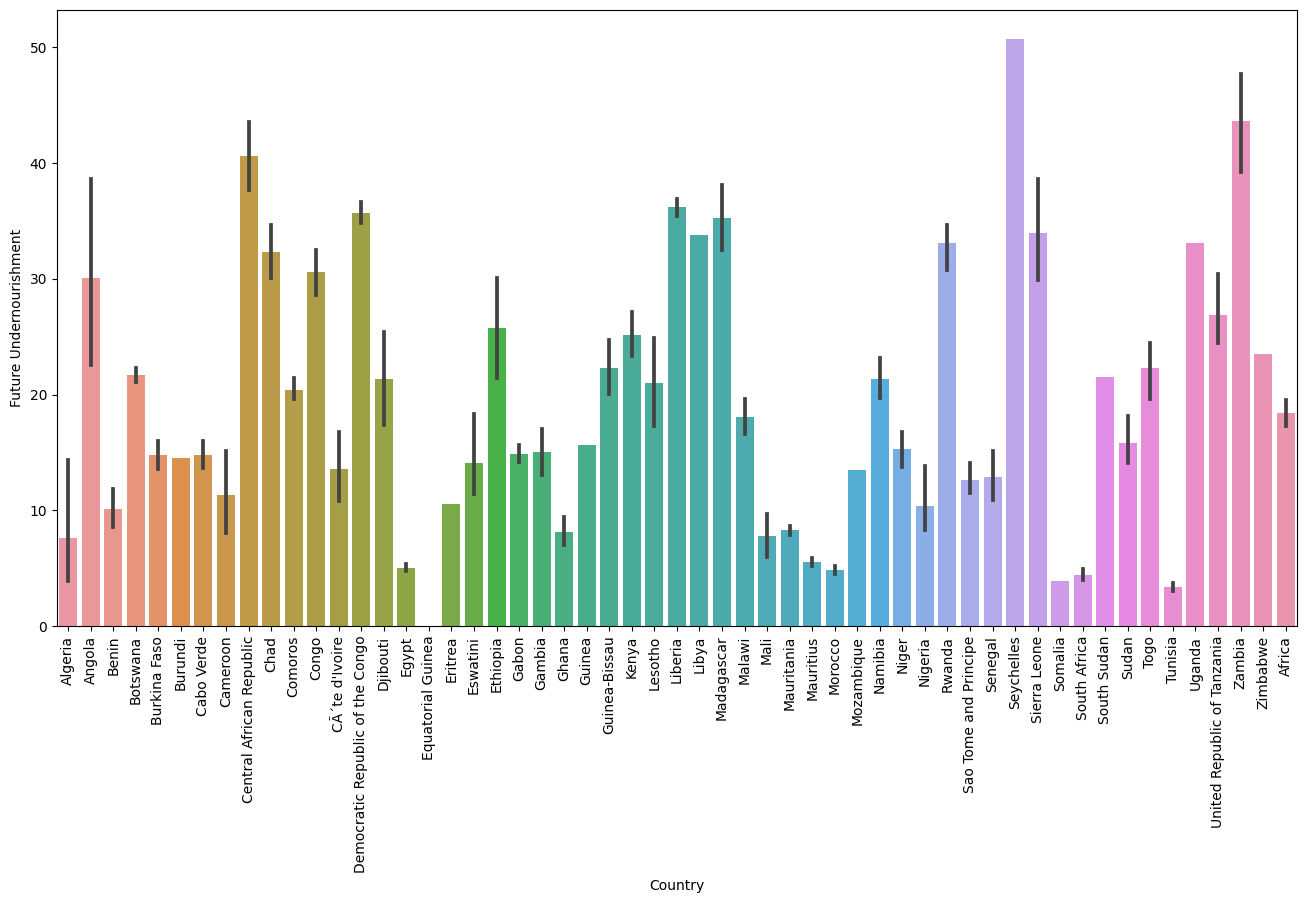

In [29]:
data = countrydf.drop(columns=['Average dietary energy supply adequacy (percent) (3-year average)',
       'Dietary energy supply used in the estimation of prevalence of undernourishment (kcal/cap/day) (3-year average)',
       'Share of dietary energy supply derived from cereals, roots and tubers (kcal/cap/day) (3-year average)',
       'Average protein supply (g/cap/day) (3-year average)',
       'Average supply of protein of animal origin (g/cap/day) (3-year average)',
       'Rail lines density (total route in km per 100 square km of land area)',
       'Gross domestic product per capita, PPP, (constant 2017 international $)',
       'Prevalence of undernourishment (percent) (3-year average)',
       'Number of people undernourished (million) (3-year average)',
       'Prevalence of severe food insecurity in the total population (percent) (3-year average)',
       'Prevalence of severe food insecurity in the male adult population (percent) (3-year average)',
       'Prevalence of severe food insecurity in the female adult population (percent) (3-year average)',
       'Prevalence of moderate or severe food insecurity in the total population (percent) (3-year average)',
       'Prevalence of moderate or severe food insecurity in the male adult population (percent) (3-year average)',
       'Prevalence of moderate or severe food insecurity in the female adult population (percent) (3-year average)',
       'Number of severely food insecure people (million) (3-year average)',
       'Number of severely food insecure male adults (million) (3-year average)',
       'Number of severely food insecure female adults (million) (3-year average)',
       'Number of moderately or severely food insecure people (million) (3-year average)',
       'Number of moderately or severely food insecure male adults (million) (3-year average)',
       'Number of moderately or severely food insecure female adults (million) (3-year average)',
       'Cereal import dependency ratio (percent) (3-year average)',
       'Percent of arable land equipped for irrigation (percent) (3-year average)',
       'Value of food imports in total merchandise exports (percent) (3-year average)',
       'Political stability and absence of violence/terrorism (index)',
       'Per capita food production variability (constant 2014-2016 thousand int$ per capita)',
       'Per capita food supply variability (kcal/cap/day)',
       'Percentage of population using safely managed drinking water services (Percent)',
       'Percentage of population using at least basic drinking water services (percent)',
       'Percentage of population using safely managed sanitation services (Percent)',
       'Percentage of population using at least basic sanitation services (percent)',
       'Percentage of children under 5 years affected by wasting (percent)',
       'Number of children under 5 years affected by wasting (million)',
       'Percentage of children under 5 years of age who are stunted (modelled estimates) (percent)',
       'Number of children under 5 years of age who are stunted (modeled estimates) (million)',
       'Percentage of children under 5 years of age who are overweight (modelled estimates) (percent)',
       'Number of children under 5 years of age who are overweight (modeled estimates) (million)',
       'Prevalence of obesity in the adult population (18 years and older)',
       'Number of obese adults (18 years and older) (million)',
       'Prevalence of anemia among women of reproductive age (15-49 years)',
       'Number of women of reproductive age (15-49 years) affected by anemia (million)',
       'Prevalence of exclusive breastfeeding among infants 0-5 months of age',
       'Prevalence of low birthweight (percent)',
       'Number of newborns with low birthweight (million)',
       'Minimum dietary energy requirement  (kcal/cap/day)',
       'Average dietary energy requirement (kcal/cap/day)',
       'Coefficient of variation of habitual caloric consumption distribution (real number)',
       'Incidence of caloric losses at retail distribution level (percent)',
       'Average fat supply (g/cap/day) (3-year average)',
       'Prevalence of undernourishment (percent) (annual value)',
       'Number of people undernourished (million) (annual value)',
       'Prevalence of severe food insecurity in the total population (percent) (annual value)',
       'Prevalence of severe food insecurity in the male adult population (percent) (annual value)',
       'Prevalence of severe food insecurity in the female adult population (percent) (annual value)',
       'Prevalence of moderate or severe food insecurity in the total population (percent) (annual value)',
       'Prevalence of moderate or severe food insecurity in the male adult population (percent) (annual value)',
       'Prevalence of moderate or severe food insecurity in the female adult population (percent) (annual value)',
       'Number of severely food insecure people (million) (annual value)',
       'Number of severely food insecure male adults (million) (annual value)',
       'Number of severely food insecure female adults (million) (annual value)',
       'Number of moderately or severely food insecure people (million) (annual value)',
       'Number of moderately or severely food insecure male adults (million) (annual value)',
       'Number of moderately or severely food insecure female adults (million) (annual value)'])
data      
fig, ax = plt.subplots(figsize=(16,8))
fig = sns.barplot(x='Country', y='Future Undernourishment', data=data)
plt.xticks(rotation=90);

# Correlation Matrix (takes 45 minto run...)

In [ ]:
'''sns.set()
#cols = countrydf.columns.to_list
sns.pairplot(countrydf)
plt.show()'''

'sns.set()\n#cols = countrydf.columns.to_list\nsns.pairplot(countrydf)\nplt.show()'

# Prediction:

## 1. Random Forest

In [44]:
# Replace all the NaNs with the column mean
dfnonan = countrydf.fillna(countrydf.mean())

C:\Users\wb8by\AppData\Local\Temp/ipykernel_34904/993854220.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dfnonan = countrydf.fillna(countrydf.mean())


In [45]:
# Build a test set and training set
X_train, X_test, y_train, y_test = train_test_split(
  dfnonan.drop(["Future Undernourishment", "Country", "Year"], axis=1), dfnonan["Future Undernourishment"], test_size=1/3)

In [51]:
# Build a random forest (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
regr = RandomForestRegressor()
# Train on the training set
regr.fit(X_train, y_train)
# predict using the test set
y_hat = regr.predict(X_test)

In [59]:
RMSE = np.sqrt((np.sum(y_hat-y_test)**2)/len(y_hat))
print("Random Forest RMSE: "+str(RMSE))

Random Forest RMSE: 3.9203951361529414


In [83]:
y_test_np = y_test.to_numpy()

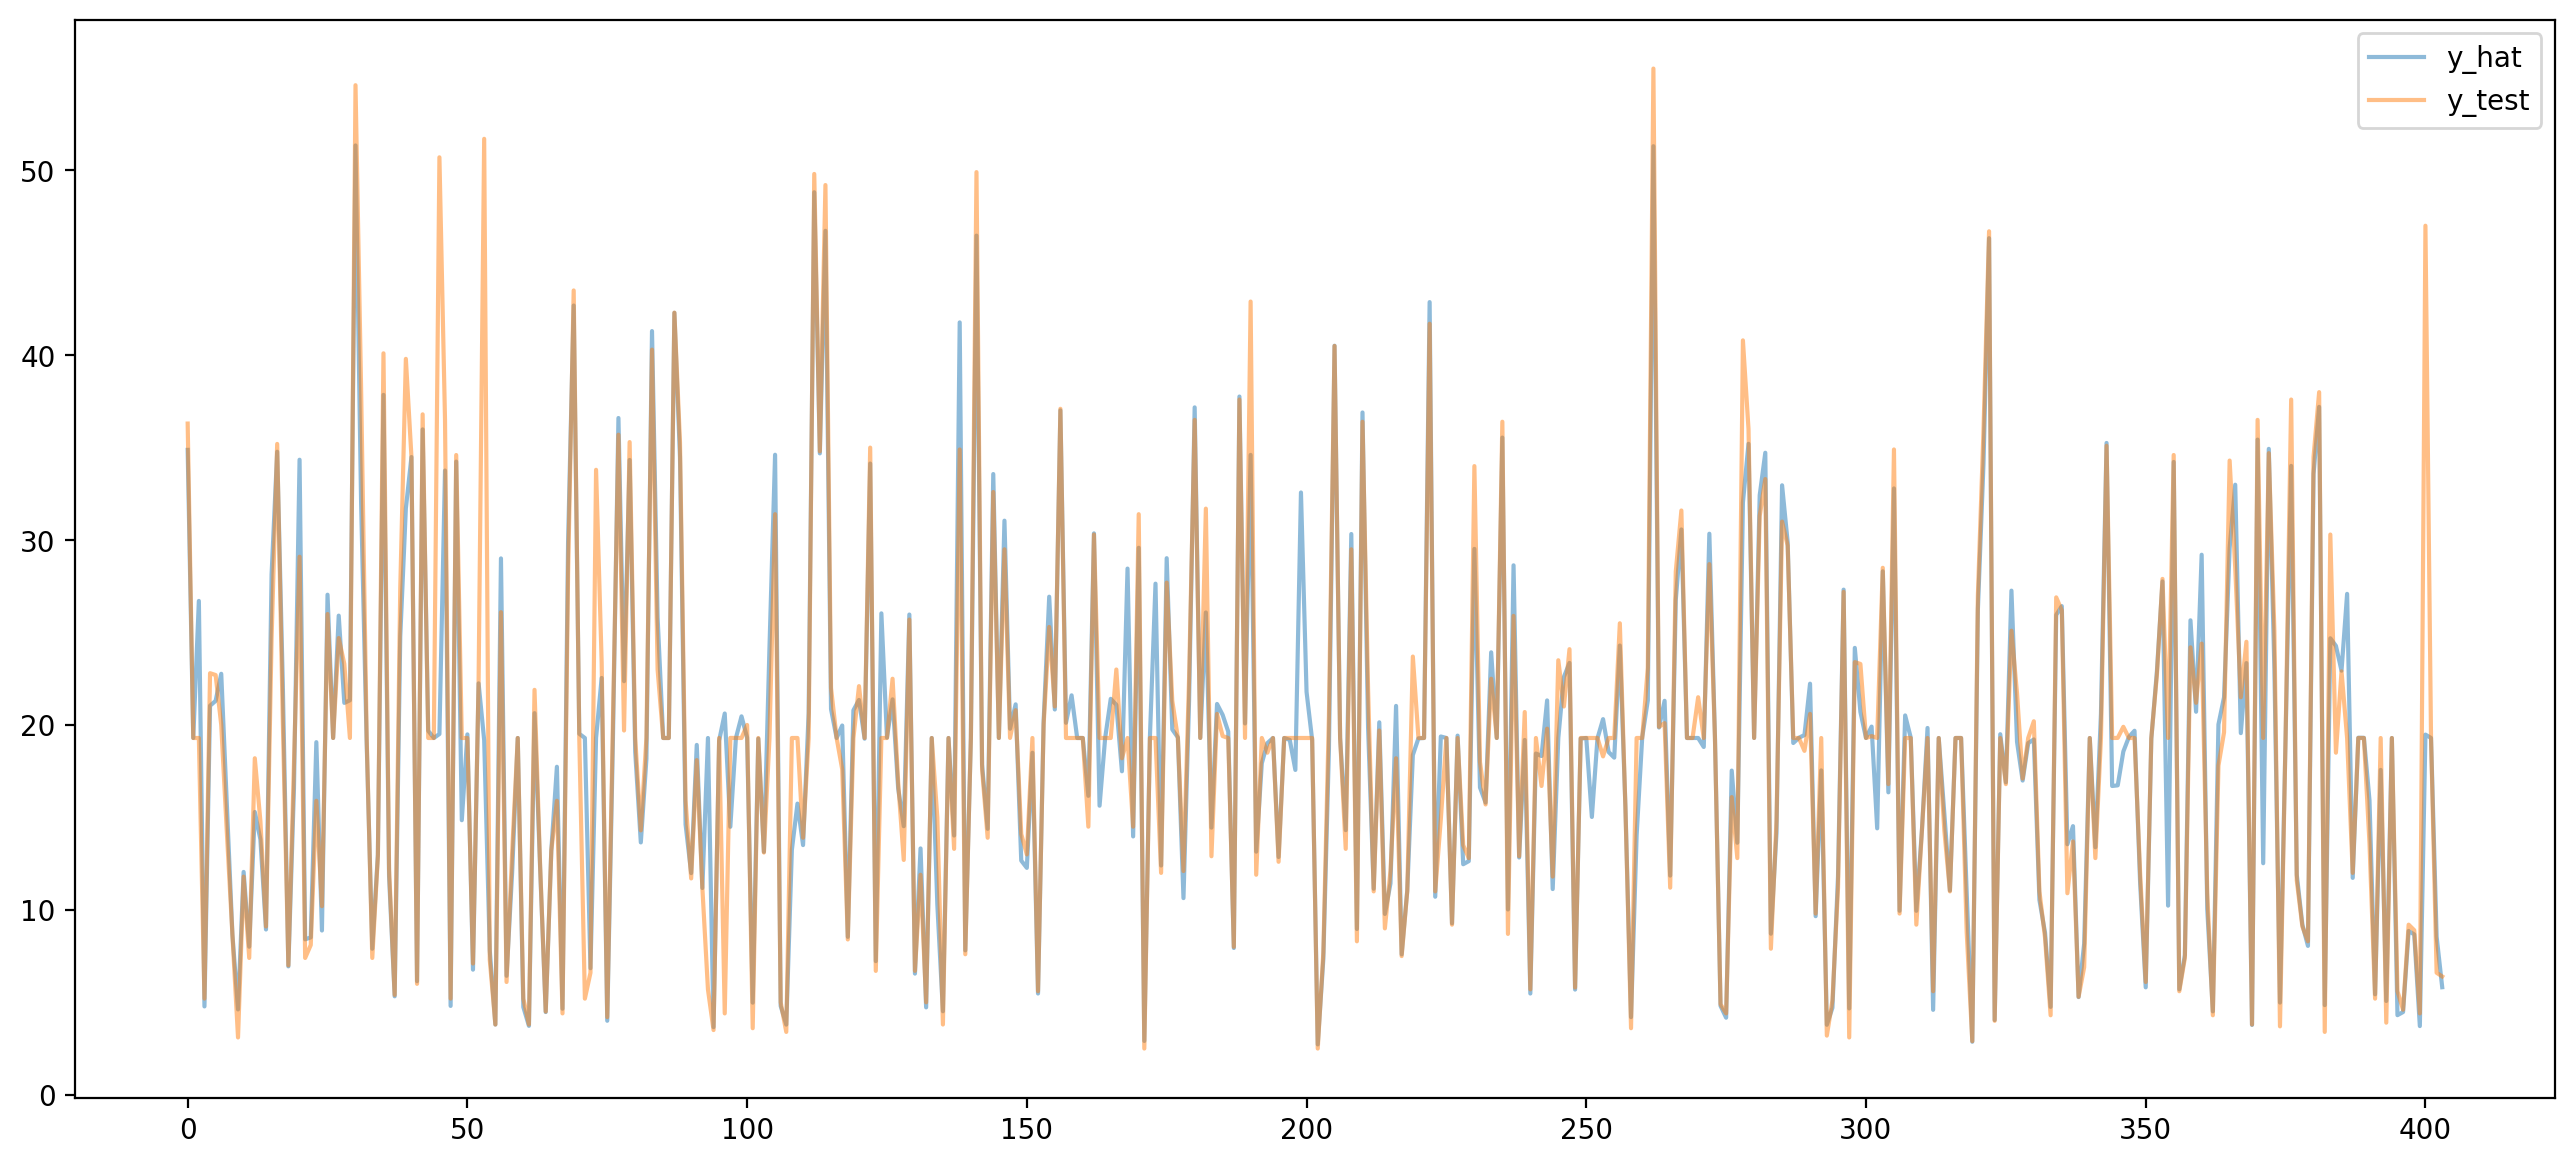

In [86]:
plt.figure(figsize=(16, 7), dpi=200)
plt.plot(y_hat, label='y_hat', alpha=0.5)
plt.plot(y_test_np, label='y_test', alpha=0.5)
plt.legend()